In [93]:
import re
import pickle
from unicodedata import normalize
from string import punctuation
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
np.random.seed(123456)

%matplotlib inline

In [122]:
def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = re.sub(r'["\'@#%\(\)$0-9]', " ", phrase)
    phrase = NLP(re.sub(r'[-+=:]', "", phrase), disable=["parser"])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != "PUNCT":
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
                try:
                    word = VERBOS[word]
                except:
                    word = palavra.lemma_
                clean_frase += [remover_acentos(word)]
                # clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
    return " ".join(clean_frase)

def _get_stopwords():
    stpwords = sorted(list(set(stopwords.words('portuguese') + list(NLP.Defaults.stop_words) + list(punctuation))))
    rms = ["um", "uma", "não", "mais", "muito", "você"]
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

# NLP = spacy.load("pt")
# STEMMER = nltk.stem.RSLPStemmer()
NLP = spacy.load('pt_core_news_sm')
STEMMER = nltk.stem.SnowballStemmer('portuguese')
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

VERBOS = {}
with open("datasets/verbs.pkc", "rb") as infile:
    verbos = pickle.load(infile)
    for verb in verbos:
        for v in list(verb.values())[0]:
            VERBOS[v] = list(verb.keys())[0]

In [123]:
dataset = 3

if dataset == 1:
    df_data = pd.read_csv("datasets/intents.csv", sep=';', names=["cluster", "perguntas"])
    df_data = df_data[df_data.columns[::-1]]
    df_data.dropna(inplace=True)
    df_data['cluster'] = df_data['cluster'].str.upper()
elif dataset == 2:
    df_data = pd.read_csv("datasets/ground_truth.csv", sep=';', names=["perguntas", "cluster"])
    df_data.dropna(inplace=True)
    df_data['cluster'] = df_data['cluster'].str.upper()
else:
    df_data1 = pd.read_csv("datasets/intents.csv", sep=';', names=["cluster", "perguntas"])
    df_data2 = pd.read_csv("datasets/ground_truth.csv", sep=';', names=["perguntas", "cluster"])

    df_data1 = df_data1[df_data1.columns[::-1]]
    df_data = pd.concat([df_data1, df_data2], sort=False)
    df_data.dropna(inplace=True)
    df_data['cluster'] = df_data['cluster'].str.upper()

T = df_data.to_numpy()
index = np.random.choice(T.shape[0], 10, replace=False)
display(df_data.iloc[index].sort_values(by=["cluster"]))

,perguntas,cluster
13,Como posso registrar um cartão SIM?,ACTIVATE_DEVICE
44,Por favor adicione o roaming internacional na ...,ACTIVATE_ROAMING
70,"Fui assaltado, preciso acionar seguro.",ADD_INSURANCE
97,"Oi, eu estava esperando que você pudesse me di...",ADD_SERVICE_FEATURES
152,Como cancelo meu serviço de telefone pré-pago?,DEACTIVATE_PREPAID_PLAN
195,Você pode verificar se posso fazer um upgrade?,DEVICE_UPGRADE_ELIGIBILITY
34,quero mudar minha password como devo proceder?,PASSWORD
24,Minha Senha está com problema,PASSWORD
45,Minha senha não funciona,PASSWORD
393,Como faço para transferir o serviço de um disp...,SWAP_DEVICE


In [124]:
text = " . ".join([tokenizer(doc) for doc in df_data['perguntas']])

In [125]:
wordcloud = WordCloud(
    background_color="white",
    width=800, height=400,
    max_words=3000,
    max_font_size=100,
    min_font_size=5
).generate(text)

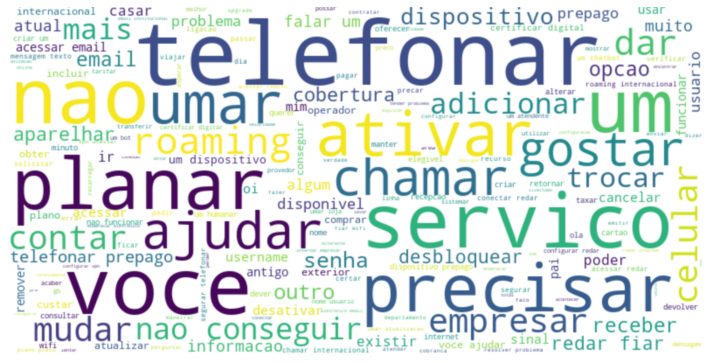

In [126]:
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bicubic')
plt.axis("off")
plt.tight_layout()
plt.show()

In [127]:
image = wordcloud.to_image()
image.save("wordcloud.jpg")